English speech recognition demo using [tugstugi/mongolian-speech-recognition](https://github.com/tugstugi/mongolian-speech-recognition) with an OCR network aka [CRNN](https://arxiv.org/abs/1507.05717) :)

An OCR model predicts from an image a sequence of characters. If you treat a spectrogram as image, a speech recognition model will also predict from an image (spectogram) a sequence of characters. So it means, you will be able to use an OCR network for the speech recognition task. Also Deepspeech can be used or the optical character recognition.

This notebook contains a CRNN network which has a same accuracy as the Mozilla DeepSpeech trained in [2017/11](https://hacks.mozilla.org/2017/11/a-journey-to-10-word-error-rate/) but trainanable on a single GPU in 15 hours. DeepSpeech was trained on 16x GPUs for more than a day.

For other deep-learning Colab notebooks, visit [tugstugi/dl-colab-notebooks](https://github.com/tugstugi/dl-colab-notebooks).

## Install

Clone the project and install the dependencies:

In [0]:
import os
import time
from os.path import exists, join, basename, splitext

git_repo_url = 'https://github.com/tugstugi/mongolian-speech-recognition.git'
project_name = splitext(basename(git_repo_url))[0]
if not exists(project_name):
  !git clone -q {git_repo_url}
  !cd {project_name} && git checkout a79b916
  !cd {project_name} && pip install -q -r requirements.txt
  !pip install -q youtube-dl wget

import sys  
sys.path.append(project_name)
  
from IPython.display import YouTubeVideo

For the language model support, we need also the `ctcdecode` lib:

In [0]:
if not exists('ctcdecode'):
  !git clone -q --recursive https://github.com/parlance/ctcdecode.git
  !cd ctcdecode && pip install .

## Download Model

Downlad the pre-trained model (16 epochs / 15 hours / 14.6% WER on LibriSpeech dev-clean) and initialize it:

In [3]:
checkpoint_file = 'checkpoint.pth'
if not exists(checkpoint_file):
  !wget -q -O {checkpoint_file} 'https://docs.google.com/uc?export=download&id=1Bt1TQD2a_RIefPW3iosa-yXtqkjehwt-'

import torch
from models.crnn import Speech2TextCRNN
from datasets.libri_speech import vocab
from utils import load_checkpoint
from decoder import *
model = Speech2TextCRNN(vocab)
load_checkpoint(checkpoint_file, model, optimizer=None, use_gpu=True)
model = model.float().cuda().eval()

loaded checkpoint epoch=16 step=118816


Download a n-gram binary language model:

In [0]:
lm_model = 'lm.binary'
if not exists(lm_model):
  !wget -q -O {lm_model} http://www.openslr.org/resources/11/3-gram.pruned.1e-7.arpa.gz
  !gunzip {lm_model}

## Test on YouTube Video

Test on some random English youtube video:

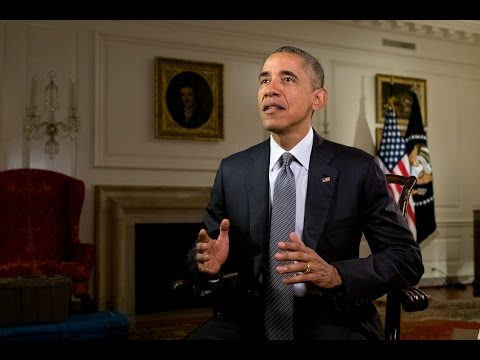

In [5]:
YOUTUBE_ID = '2AFpAATHXtc'


YouTubeVideo(YOUTUBE_ID)

In [0]:
# download the youtube video and read as audio
!rm -rf *.wav
!youtube-dl --extract-audio --audio-format wav --output "test.%(ext)s" https://www.youtube.com/watch\?v\={YOUTUBE_ID}
  

from datasets import *
audio = Compose([LoadAudio(), ComputeMelSpectrogram(), ResizeMelSpectrogram()])({'fname': 'test.wav', 'text':''})['input']

torch.set_grad_enabled(False)
inputs = torch.from_numpy(audio).unsqueeze(0)
inputs = inputs.permute(0, 2, 1).cuda()
outputs = model(inputs)
outputs = outputs.softmax(2).permute(1, 0, 2)

Let's decode first with the gready decoder (without any language model):

In [7]:
greedy_decoder = GreedyDecoder(labels=vocab)
decoded_output, _ = greedy_decoder.decode(outputs)
print(decoded_output[0][0])

 i verybody in our house everybody knows that president is only  the third most important job in the family so this we an a menitagonlol extra time to say thank you to michel for the remarkable way she does the most important jo being a ma and wenn a give extra thanks to my mother in law for the rol mill sheis always been to michel and the countless solfless ways in which shes selt we shell on me raise mellian sauch i am incredibly loki to have these wonderful woman help me raise lovve and look after auncles i hope you'l also take a moment to siy thank you to the women in your life who love you am mat special way mams do mlogical mams e doptive mams and fostermovs single mas grandmals god mothers os mentors whomever you think of whe you think of mother's daye mor take a moment like i will to remember the mams who raisedus was big hart sustained us and whom we miss every day no mattor hold we yet eveyg flowers is always a good idea but i hoped that on this mother's day will recommit our

Now use a language model, in most cases it will produce a better prediction:

In [8]:
ALPHA = 0.3  # How much do you trust for LM? 0 means don't use LM, bigger values more trust in LM
BETA = 1.85  # not so important, using DeepSpeech default one
beam_ctc_decoder = BeamCTCDecoder(labels='$' + vocab[1:].upper(), num_processes=4,
                                          lm_path=lm_model,
                                          alpha=ALPHA, beta=BETA,
                                          cutoff_top_n=40, cutoff_prob=1.0, beam_width=1000)
decoded_output, _ = beam_ctc_decoder.decode(outputs)
print(decoded_output[0][0].lower())

i i everybody in our house everybody knows that president is only the third most important job in the family so this we can a meditatin al extra time to say thank you to michel for the remarkable way she does the most important job being a mat and won a given extra thanks to my mother in law for the roll mill she's always been to michel and the countless selfless ways in which she self we shell on me raise million such i am incredibly loki to have these wonderful woman help me raise love and look after ancles i hope you also take a moment to say thank you to the women in your life who love you a mat special way moms do logical moms adoptive moms and foster mops single mass grandmas god mothers as mentors whomever you think of when you think of mother's day or take a moment like i will to remember the moms who raised us was big hard sustained us and whom we miss every day no matter hold we yet even flowers is always a good idea but i hope that on this mother's day will recommitted to du